In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/5g-nidd-dataset/Combined.csv


In [58]:
# import shutil

# input_path = '/kaggle/input/5g-nidd-dataset'
# output_path = '/kaggle/temp/5g-nidd-dataset'
# # Copy dataset into working directory
# shutil.copytree(input_path, output_path)

In [59]:
cd /kaggle/temp/5g-nidd-dataset

/kaggle/temp/5g-nidd-dataset


In [60]:
!pip install fancyimpute
!pip install torch
!pip install scipy

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io
import missingno as msno
import multiprocessing
import scipy
import sklearn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F

In [62]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import fancyimpute
from fancyimpute import IterativeImputer

In [63]:
df = pd.read_csv('Combined.csv', low_memory=False)
df.head()

,Unnamed: 0,Seq,Dur,RunTime,Mean,Sum,Min,Max,Proto,sTos,...,sVid,dVid,SrcTCPBase,DstTCPBase,TcpRtt,SynAck,AckDat,Label,Attack Type,Attack Tool
0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
1,1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,icmp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
2,2,3,4.998020,4.998020,4.998020,4.998020,4.998020,4.998020,udp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
3,3,4,4.998037,4.998037,4.998037,4.998037,4.998037,4.998037,udp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign
4,4,5,4.999453,4.999453,4.999453,4.999453,4.999453,4.999453,udp,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,Benign,Benign,Benign


In [64]:
print(df.shape)

(1215890, 52)


In [65]:
pd.set_option('float_format', '{:f}'.format)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["xtick.labelsize"] = 7
pd.set_option('future.no_silent_downcasting', True)

In [66]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [67]:
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Torch 2.1.2 CUDA 12.1
Device: cuda:0


In [68]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.05

num_classes = df['Attack Type'].nunique()
num_classes

9

In [69]:
# Segregate features and labels into separate variables
X, y = df.iloc[:, :-2].values, df.iloc[:, [-2]].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.05)

X_train = pd.DataFrame(X_train, columns=df.columns.to_list()[:-2])
X_test = pd.DataFrame(X_test, columns=df.columns.to_list()[:-2])
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1155095, 50)
Testing dataset size: (60795, 50)
Training target size: (1155095, 1)
Testing target size: (60795, 1)


In [70]:
# Define a function to impute NaN values with the most frequent value in the group
def impute_most_frequent(group):
    mode_value = group.mode().iloc[0] if not group.mode().empty else np.nan
    return group.fillna(mode_value)

def handle_missing_values(df):
    df.drop_duplicates(inplace=True)
    df.drop(['sVid', 'dVid'], axis=1, inplace=True)
    df.dropna(subset=['sTos', 'sHops', 'sTtl', 'sDSb'], how='any', inplace=True)
    df[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']] = df.groupby('Attack Type')[['dTtl', 'dDSb', 'dTos', 'dHops', 'SrcGap', 'DstGap']].transform(impute_most_frequent)
    df['dDSb'] = df['dDSb'].fillna('cs0')
    
    df_subset_copy = df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']].copy(deep=True)
    mice_imputer = IterativeImputer()
    df_subset_copy.iloc[:, :] = mice_imputer.fit_transform(df_subset_copy)
    df[['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin']] = df_subset_copy

In [71]:
train_df = pd.concat([X_train, y_train], axis='columns')
handle_missing_values(train_df)
print(train_df.shape)
train_df.isna().any()

(1154890, 49)


Unnamed: 0     False
Seq            False
Dur            False
RunTime        False
Mean           False
Sum            False
Min            False
Max            False
Proto          False
sTos           False
dTos           False
sDSb           False
dDSb           False
sTtl           False
dTtl           False
sHops          False
dHops          False
Cause          False
TotPkts        False
SrcPkts        False
DstPkts        False
TotBytes       False
SrcBytes       False
DstBytes       False
Offset         False
sMeanPktSz     False
dMeanPktSz     False
Load           False
SrcLoad        False
DstLoad        False
Loss           False
SrcLoss        False
DstLoss        False
pLoss          False
SrcGap         False
DstGap         False
Rate           False
SrcRate        False
DstRate        False
State          False
SrcWin         False
DstWin         False
SrcTCPBase     False
DstTCPBase     False
TcpRtt         False
SynAck         False
AckDat         False
Label        

In [72]:
def impute_most_frequent_test(group, col="col", df=pd.DataFrame()):
    print(group.shape)
    mode_value = group.mode().iloc[0] if not group.mode().empty else 0.0
    return test_df[col].fillna(mode_value)    
    
# ToDo: Perform better imputation for test dataset    
def handle_missing_values_test(test_df, train_df):
    test_df.drop_duplicates(inplace=True)
    test_df.drop(['sVid', 'dVid'], axis=1, inplace=True)
    test_df.dropna(subset=['sTos', 'sHops', 'sTtl', 'sDSb'], how='any', inplace=True)
    
    # Calculate the mode of each category in the training dataset
    mode_values = train_df.mode().iloc[0]    
    
    # Replace missing values in the test dataset with the mode from the training dataset
    for col in ['dTtl', 'dTos', 'dHops', 'SrcGap', 'DstGap', 'SrcTCPBase', 'DstTCPBase', 'SrcWin', 'DstWin', 'dDSb']:
        test_df[col] = test_df[col].fillna(mode_values[col])

In [73]:
test_df = pd.concat([X_test, y_test], axis='columns')
handle_missing_values_test(test_df, train_df)
print(test_df.shape)
test_df.isna().any()

(60786, 49)


Unnamed: 0     False
Seq            False
Dur            False
RunTime        False
Mean           False
Sum            False
Min            False
Max            False
Proto          False
sTos           False
dTos           False
sDSb           False
dDSb           False
sTtl           False
dTtl           False
sHops          False
dHops          False
Cause          False
TotPkts        False
SrcPkts        False
DstPkts        False
TotBytes       False
SrcBytes       False
DstBytes       False
Offset         False
sMeanPktSz     False
dMeanPktSz     False
Load           False
SrcLoad        False
DstLoad        False
Loss           False
SrcLoss        False
DstLoss        False
pLoss          False
SrcGap         False
DstGap         False
Rate           False
SrcRate        False
DstRate        False
State          False
SrcWin         False
DstWin         False
SrcTCPBase     False
DstTCPBase     False
TcpRtt         False
SynAck         False
AckDat         False
Label        

In [74]:
X_train, y_train = train_df.loc[:, train_df.columns != 'Attack Type'], train_df['Attack Type']
print("Training dataset size:", X_train.shape)
print("Training target size:", y_train.shape)

Training dataset size: (1154890, 48)
Training target size: (1154890,)


In [75]:
X_test, y_test = test_df.loc[:, test_df.columns != 'Attack Type'], test_df['Attack Type']
print("Testing dataset size:", X_test.shape)
print("Testing target size:", y_test.shape)

Testing dataset size: (60786, 48)
Testing target size: (60786,)


In [76]:
df = pd.concat([train_df, test_df], axis = 0)
print(df.shape)

(1215676, 49)


In [77]:
def one_hot_encode(df):
    proto_dummies = pd.get_dummies(df.Proto, dtype=int, prefix='Proto')
    proto_dummies.drop(columns=['Proto_ipv6-icmp'], inplace=True)
    sDSb_dummies = pd.get_dummies(df.sDSb, dtype=int, prefix='sDSb')
    sDSb_dummies.drop(columns=['sDSb_39','sDSb_54', 'sDSb_4', 'sDSb_cs4'], inplace=True)
    dDSb_dummies = pd.get_dummies(df.dDSb, dtype=int, prefix='dDSb')
    dDSb_dummies.drop(columns=['dDSb_cs4'], inplace=True)
    Cause_dummies = pd.get_dummies(df.Cause, dtype=int, prefix='Cause')
    Cause_dummies.drop(columns=['Cause_Shutdown'], inplace=True)
    State_dummies = pd.get_dummies(df.State, dtype=int, prefix='State')
    State_dummies.drop(columns=['State_RSP','State_TST','State_NRS'], inplace=True)
    df = pd.concat([df, proto_dummies, sDSb_dummies, dDSb_dummies, Cause_dummies, State_dummies], axis='columns')
    df.drop(columns=['Proto', 'sDSb', 'dDSb', 'Cause', 'State', 'Label', 'Unnamed: 0', 'Seq', 'RunTime', 'Mean', 'Sum', 'Min', 'Max'], inplace=True)
    return df

In [78]:
df = one_hot_encode(df)

# Split
train_df, test_df = df.iloc[:X_train.shape[0], :], df.iloc[X_train.shape[0]:, :]
print("Training dataset size:", train_df.shape)
print("Training target size:", test_df.shape)

Training dataset size: (1154890, 63)
Training target size: (60786, 63)


In [79]:
X_train, y_train = train_df.loc[:, train_df.columns != 'Attack Type'], train_df['Attack Type']
print("Training dataset size:", X_train.shape)
print("Training target size:", y_train.shape)

Training dataset size: (1154890, 62)
Training target size: (1154890,)


In [80]:
X_test, y_test = test_df.loc[:, test_df.columns != 'Attack Type'], test_df['Attack Type']
print("Testing dataset size:", X_test.shape)
print("Testing target size:", y_test.shape)

Testing dataset size: (60786, 62)
Testing target size: (60786,)


In [81]:
print(X_train.head())
X_train.columns

       Dur     sTos     dTos       sTtl      dTtl     sHops    dHops TotPkts  \
0 4.905026 0.000000 0.000000 117.000000 64.000000 11.000000 0.000000     152   
1 2.759967 0.000000 0.000000  63.000000 64.000000  1.000000 0.000000       2   
2 0.000000 0.000000 0.000000  63.000000 64.000000  1.000000 0.000000       1   
3 0.000000 0.000000 0.000000 249.000000 64.000000  7.000000 0.000000       1   
4 2.576845 0.000000 0.000000  63.000000 64.000000  1.000000 0.000000       2   

  SrcPkts DstPkts  ... Cause_Start Cause_Status State_ACC State_CON State_ECO  \
0     126      26  ...           0            1         0         1         0   
1       2       0  ...           1            0         0         0         0   
2       1       0  ...           0            1         0         0         0   
3       1       0  ...           1            0         0         0         0   
4       2       0  ...           0            1         0         0         0   

  State_FIN State_INT State_REQ 

Index(['Dur', 'sTos', 'dTos', 'sTtl', 'dTtl', 'sHops', 'dHops', 'TotPkts',
       'SrcPkts', 'DstPkts', 'TotBytes', 'SrcBytes', 'DstBytes', 'Offset',
       'sMeanPktSz', 'dMeanPktSz', 'Load', 'SrcLoad', 'DstLoad', 'Loss',
       'SrcLoss', 'DstLoss', 'pLoss', 'SrcGap', 'DstGap', 'Rate', 'SrcRate',
       'DstRate', 'SrcWin', 'DstWin', 'SrcTCPBase', 'DstTCPBase', 'TcpRtt',
       'SynAck', 'AckDat', 'Proto_icmp', 'Proto_sctp', 'Proto_tcp',
       'Proto_udp', 'sDSb_52', 'sDSb_af11', 'sDSb_af12', 'sDSb_af41',
       'sDSb_cs0', 'sDSb_cs6', 'sDSb_cs7', 'sDSb_ef', 'dDSb_af11', 'dDSb_af12',
       'dDSb_cs0', 'dDSb_cs1', 'dDSb_ef', 'Cause_Start', 'Cause_Status',
       'State_ACC', 'State_CON', 'State_ECO', 'State_FIN', 'State_INT',
       'State_REQ', 'State_RST', 'State_URP'],
      dtype='object')

In [82]:
def normalize_dataframe(df):
    std_scaler = preprocessing.StandardScaler()
    std_normalized = std_scaler.fit_transform(df)
    df = pd.DataFrame(std_normalized, columns = df.columns)
    return df

In [83]:
X_train = normalize_dataframe(X_train)
X_train.head()

,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Start,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP
0,2.093617,-0.069130,-0.094858,0.635442,-0.007377,2.453084,-0.973006,5.984565,6.655773,2.024796,...,-0.817070,0.818056,-0.030295,2.863571,-0.155817,-0.226235,-0.608901,-0.969699,-0.257460,-0.025424
1,0.825105,-0.069130,-0.094858,-0.330008,-0.007377,-0.352699,-0.973006,-0.127855,-0.092318,-0.118821,...,1.223886,-1.222410,-0.030295,-0.349214,-0.155817,-0.226235,1.642304,-0.969699,-0.257460,-0.025424
2,-0.807042,-0.069130,-0.094858,-0.330008,-0.007377,-0.352699,-0.973006,-0.168604,-0.146738,-0.118821,...,-0.817070,0.818056,-0.030295,-0.349214,-0.155817,-0.226235,-0.608901,1.031248,-0.257460,-0.025424
3,-0.807042,-0.069130,-0.094858,2.995433,-0.007377,1.330771,-0.973006,-0.168604,-0.146738,-0.118821,...,1.223886,-1.222410,-0.030295,-0.349214,-0.155817,-0.226235,1.642304,-0.969699,-0.257460,-0.025424
4,0.716813,-0.069130,-0.094858,-0.330008,-0.007377,-0.352699,-0.973006,-0.127855,-0.092318,-0.118821,...,-0.817070,0.818056,-0.030295,-0.349214,-0.155817,-0.226235,-0.608901,1.031248,-0.257460,-0.025424


In [84]:
train_df = pd.concat([X_train, y_train], axis='columns')
print(train_df.shape)
train_df.head()

(1155095, 63)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,2.093617,-0.069130,-0.094858,0.635442,-0.007377,2.453084,-0.973006,5.984565,6.655773,2.024796,...,0.818056,-0.030295,2.863571,-0.155817,-0.226235,-0.608901,-0.969699,-0.257460,-0.025424,Benign
1,0.825105,-0.069130,-0.094858,-0.330008,-0.007377,-0.352699,-0.973006,-0.127855,-0.092318,-0.118821,...,-1.222410,-0.030295,-0.349214,-0.155817,-0.226235,1.642304,-0.969699,-0.257460,-0.025424,Benign
2,-0.807042,-0.069130,-0.094858,-0.330008,-0.007377,-0.352699,-0.973006,-0.168604,-0.146738,-0.118821,...,0.818056,-0.030295,-0.349214,-0.155817,-0.226235,-0.608901,1.031248,-0.257460,-0.025424,Benign
3,-0.807042,-0.069130,-0.094858,2.995433,-0.007377,1.330771,-0.973006,-0.168604,-0.146738,-0.118821,...,-1.222410,-0.030295,-0.349214,-0.155817,-0.226235,1.642304,-0.969699,-0.257460,-0.025424,Benign
4,0.716813,-0.069130,-0.094858,-0.330008,-0.007377,-0.352699,-0.973006,-0.127855,-0.092318,-0.118821,...,0.818056,-0.030295,-0.349214,-0.155817,-0.226235,-0.608901,1.031248,-0.257460,-0.025424,Benign


In [85]:
X_test = normalize_dataframe(X_test)
X_test.head()

,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Start,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP
0,0.709710,-0.067434,-0.057610,-0.329362,-0.020107,-0.352578,-0.395879,-0.111125,-0.093754,-0.085006,...,-0.811792,0.812713,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,1.031693,-0.260974,-0.025661
1,-0.807889,-0.067434,-0.057610,3.002915,-0.020107,1.328766,-0.395879,-0.144823,-0.146042,-0.085006,...,1.231842,-1.230447,-0.028692,-0.349418,-0.156158,-0.225805,1.647885,-0.969280,-0.260974,-0.025661
2,-0.807889,-0.067434,-0.057610,-0.418939,-0.020107,1.048542,-0.395879,-0.144823,-0.146042,-0.085006,...,1.231842,-1.230447,-0.028692,-0.349418,6.403772,-0.225805,-0.606838,-0.969280,-0.260974,-0.025661
3,-0.807889,-0.067434,-0.057610,-0.329362,-0.020107,-0.352578,-0.395879,-0.144823,-0.146042,-0.085006,...,1.231842,-1.230447,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,1.031693,-0.260974,-0.025661
4,0.389375,-0.067434,-0.057610,-0.329362,-0.408286,-0.352578,1.329789,0.057366,-0.041467,0.140986,...,-0.811792,0.812713,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,-0.969280,3.831796,-0.025661


In [86]:
test_df = pd.concat([X_test, y_test], axis='columns')
print(test_df.shape)
test_df.head()

(60795, 63)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,0.709710,-0.067434,-0.057610,-0.329362,-0.020107,-0.352578,-0.395879,-0.111125,-0.093754,-0.085006,...,0.812713,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,1.031693,-0.260974,-0.025661,Benign
1,-0.807889,-0.067434,-0.057610,3.002915,-0.020107,1.328766,-0.395879,-0.144823,-0.146042,-0.085006,...,-1.230447,-0.028692,-0.349418,-0.156158,-0.225805,1.647885,-0.969280,-0.260974,-0.025661,Benign
2,-0.807889,-0.067434,-0.057610,-0.418939,-0.020107,1.048542,-0.395879,-0.144823,-0.146042,-0.085006,...,-1.230447,-0.028692,-0.349418,6.403772,-0.225805,-0.606838,-0.969280,-0.260974,-0.025661,Benign
3,-0.807889,-0.067434,-0.057610,-0.329362,-0.020107,-0.352578,-0.395879,-0.144823,-0.146042,-0.085006,...,-1.230447,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,1.031693,-0.260974,-0.025661,TCPConnectScan
4,0.389375,-0.067434,-0.057610,-0.329362,-0.408286,-0.352578,1.329789,0.057366,-0.041467,0.140986,...,0.812713,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,-0.969280,3.831796,-0.025661,SlowrateDoS


In [87]:
class CustomTabularDataset(Dataset):
    def __init__(self, data):
        # Load and preprocess your tabular data here
        self.features = torch.tensor(data['features'].values, dtype=torch.float32)
        self.labels = torch.tensor(data['labels'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [88]:
from sklearn.preprocessing import LabelEncoder

# define ordinal encoding
le = LabelEncoder()

# transform data
le.fit(y_train.iloc[:].values)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}


In [89]:
y_test = le.fit_transform(y_test.iloc[:].values.ravel())
y_test = pd.DataFrame(y_test, columns=['Attack Type'])
y_test['Attack Type'] = pd.to_numeric(y_test['Attack Type'], downcast='integer')
y_test.head()

,Attack Type
0,0
1,0
2,0
3,6
4,5


In [90]:
y_test.nunique()

Attack Type    9
dtype: int64

In [91]:
y_train = le.fit_transform(y_train.iloc[:].values.ravel())
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_train['Attack Type'] = pd.to_numeric(y_train['Attack Type'], downcast='integer')
y_train.head()

,Attack Type
0,0
1,0
2,0
3,0
4,0


In [92]:
print(le.classes_)
print(list(le.transform(le.classes_)))

['Benign' 'HTTPFlood' 'ICMPFlood' 'SYNFlood' 'SYNScan' 'SlowrateDoS'
 'TCPConnectScan' 'UDPFlood' 'UDPScan']
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [93]:
# obtain training indices that will be used for validation
num_train = len(X_train)
indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [94]:
print('Training set size:', num_train - split)
print('Validation set size:', split)
print('Testing set size:', len(X_test))

Training set size: 1097146
Validation set size: 57744
Testing set size: 60786


In [95]:
train_data = {'features': X_train,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_train}     # Your label data

dataset = CustomTabularDataset(train_data)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)

In [96]:
# Number of features
num_features = X_train.shape[1]

In [97]:
# Creating a PyTorch class
# input_features ==> 12 ==> 32
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Tanh activation function
        # input_features ===> 12
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_features, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 12),
            torch.nn.Tanh(),  
        )
        
        # Dense neural network layers
        self.dense_nn = torch.nn.Sequential(
            torch.nn.Linear(12, 32),  # Input size is 12 from the encoder
            torch.nn.BatchNorm1d(32),            
            torch.nn.ReLU(), 
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, 64),
            torch.nn.BatchNorm1d(64),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),              
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),                
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),            
            torch.nn.Linear(32, num_classes),  # Output size is the number of classes
            torch.nn.Softmax(dim=1)
        )        

    def forward(self, x):
        encoded = self.encoder(x)
        output = self.dense_nn(encoded)
        return output

In [98]:
# Model Initialization
model = Autoencoder()

# Validation using MSE Loss function
loss_function = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 0.001,
                            weight_decay = 1e-8)


In [99]:
# number of epochs to train the model
n_epochs = 8

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
train_loss_min = np.Inf # set initial "min" to infinity

# Lists to store training and validation accuracy during training
training_loss = np.array([])
validation_loss = np.array([])

training_accuracy = np.array([])
validation_accuracy = np.array([])

# Moving model tensor to GPU if available
model = model.to(device)

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_valid_correct = 0
    total_valid_samples = 0

    ###################
    # train the model #
    ###################

    # model by default is set to train
    model.train()

    for data, target in tqdm(train_loader):        

        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)

        # Forward prop:

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())    
        
        # Moving output tensor to GPU if available
        output = output.to(device)

        # calculate the batch loss
        loss = loss_function(output, target.reshape(-1).long())
        
        # Backward prop:

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # Metrics:

        # update training loss
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_train_samples += target.size(0)


    ######################
    # validate the model #
    ######################

    model.eval() # prep model for evaluation

    for data, target in tqdm(valid_loader):
        
        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        output = output.to(device)
        
        # calculate the loss
        loss = loss_function(output, target.reshape(-1).long())        
        
        # update running validation loss
        valid_loss += loss.item()
        
        # Calculate validation accuracy
        _, predicted = torch.max(output, 1)
        total_valid_correct += (predicted == target.view(*predicted.shape)).sum().item()
        total_valid_samples += target.size(0)


    # print training/validation statistics
    
    train_acc = 100 * total_train_correct / total_train_samples
    valid_acc = 100 * total_valid_correct / total_valid_samples
    
    training_accuracy = np.append(training_accuracy, train_acc)
    validation_accuracy = np.append(validation_accuracy, valid_acc)
    
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    training_loss = np.append(training_loss, train_loss)
    validation_loss = np.append(validation_loss, valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch,
        train_acc,
        valid_acc
    ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min and train_loss <= train_loss_min:
        print('Training loss decreased ({:.6f} --> {:.6f}).'.format(
            train_loss_min,
            train_loss))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_pytorch_autoencoders.pt')
        valid_loss_min = valid_loss
        train_loss_min = train_loss

100%|██████████| 903/903 [00:02<00:00, 301.64it/s]


Epoch: 1 	Training Loss: 1.389571 	Validation Loss: 1.376685
Epoch: 1 	Training Accuracy: 98.479783 	Validation Accuracy: 99.525492
Training loss decreased (inf --> 1.389571).
Validation loss decreased (inf --> 1.376685).  Saving model ...


100%|██████████| 903/903 [00:03<00:00, 299.16it/s]


Epoch: 2 	Training Loss: 1.378095 	Validation Loss: 1.376326
Epoch: 2 	Training Accuracy: 99.392332 	Validation Accuracy: 99.560127
Training loss decreased (1.389571 --> 1.378095).
Validation loss decreased (1.376685 --> 1.376326).  Saving model ...


100%|██████████| 903/903 [00:03<00:00, 290.50it/s]


Epoch: 3 	Training Loss: 1.377136 	Validation Loss: 1.375114
Epoch: 3 	Training Accuracy: 99.485210 	Validation Accuracy: 99.683084
Training loss decreased (1.378095 --> 1.377136).
Validation loss decreased (1.376326 --> 1.375114).  Saving model ...


100%|██████████| 903/903 [00:02<00:00, 301.99it/s]


Epoch: 4 	Training Loss: 1.376592 	Validation Loss: 1.375408
Epoch: 4 	Training Accuracy: 99.539988 	Validation Accuracy: 99.653644


100%|██████████| 903/903 [00:03<00:00, 295.80it/s]


Epoch: 5 	Training Loss: 1.376524 	Validation Loss: 1.376619
Epoch: 5 	Training Accuracy: 99.545184 	Validation Accuracy: 99.530687


100%|██████████| 903/903 [00:03<00:00, 251.17it/s]


Epoch: 6 	Training Loss: 1.376246 	Validation Loss: 1.375000
Epoch: 6 	Training Accuracy: 99.572618 	Validation Accuracy: 99.695206
Training loss decreased (1.377136 --> 1.376246).
Validation loss decreased (1.375114 --> 1.375000).  Saving model ...


100%|██████████| 903/903 [00:03<00:00, 278.35it/s]


Epoch: 7 	Training Loss: 1.376182 	Validation Loss: 1.374921
Epoch: 7 	Training Accuracy: 99.578907 	Validation Accuracy: 99.703865
Training loss decreased (1.376246 --> 1.376182).
Validation loss decreased (1.375000 --> 1.374921).  Saving model ...


100%|██████████| 903/903 [00:03<00:00, 268.87it/s]

Epoch: 8 	Training Loss: 1.375988 	Validation Loss: 1.375623
Epoch: 8 	Training Accuracy: 99.597592 	Validation Accuracy: 99.627667


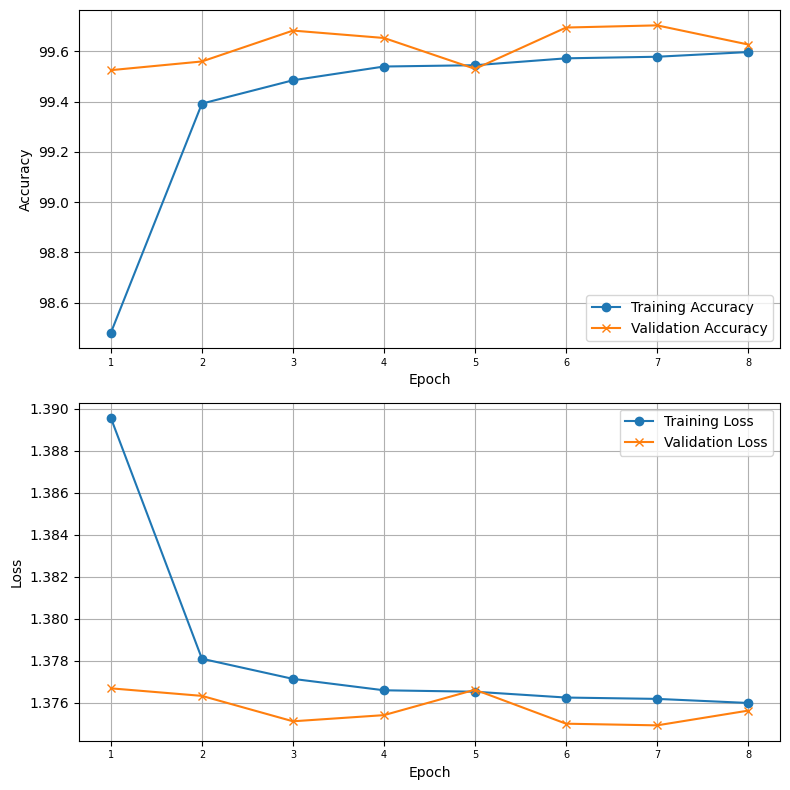

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
epochs = np.arange(1, n_epochs+1)

# First row for accuracy
ax[0].plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
ax[0].plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy', color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].legend(loc='lower right')
ax[0].grid(True)

# Second row for loss
ax[1].plot(epochs, training_loss, label='Training Loss', marker='o')
ax[1].plot(epochs, validation_loss, label='Validation Loss', marker='x')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss', color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Testing phase:

In [106]:
print("Testing dataset size:", X_test.shape)
print("Testing target size:", y_test.shape)
print("Test df size:", test_df.shape)

test_df.head()

Testing dataset size: (60786, 62)
Testing target size: (60786, 1)
Test df size: (60774, 63)


,Dur,sTos,dTos,sTtl,dTtl,sHops,dHops,TotPkts,SrcPkts,DstPkts,...,Cause_Status,State_ACC,State_CON,State_ECO,State_FIN,State_INT,State_REQ,State_RST,State_URP,Attack Type
0,0.709710,-0.067434,-0.057610,-0.329362,-0.020107,-0.352578,-0.395879,-0.111125,-0.093754,-0.085006,...,0.812713,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,1.031693,-0.260974,-0.025661,0
1,-0.807889,-0.067434,-0.057610,3.002915,-0.020107,1.328766,-0.395879,-0.144823,-0.146042,-0.085006,...,-1.230447,-0.028692,-0.349418,-0.156158,-0.225805,1.647885,-0.969280,-0.260974,-0.025661,0
2,-0.807889,-0.067434,-0.057610,-0.418939,-0.020107,1.048542,-0.395879,-0.144823,-0.146042,-0.085006,...,-1.230447,-0.028692,-0.349418,6.403772,-0.225805,-0.606838,-0.969280,-0.260974,-0.025661,0
3,-0.807889,-0.067434,-0.057610,-0.329362,-0.020107,-0.352578,-0.395879,-0.144823,-0.146042,-0.085006,...,-1.230447,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,1.031693,-0.260974,-0.025661,6
4,0.389375,-0.067434,-0.057610,-0.329362,-0.408286,-0.352578,1.329789,0.057366,-0.041467,0.140986,...,0.812713,-0.028692,-0.349418,-0.156158,-0.225805,-0.606838,-0.969280,3.831796,-0.025661,5


In [111]:
y_test.head()

,Attack Type
0,0
1,0
2,0
3,6
4,5


In [107]:
test_data = {'features': X_test,  # Your feature data (Pandas DataFrame or similar)
        'labels': y_test}     # Your label data

test_dataset = CustomTabularDataset(test_data)

In [108]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

In [109]:
model.load_state_dict(torch.load('model_pytorch_autoencoders.pt'))

<All keys matched successfully>

In [112]:
le_name_mapping

{'Benign': 0,
 'HTTPFlood': 1,
 'ICMPFlood': 2,
 'SYNFlood': 3,
 'SYNScan': 4,
 'SlowrateDoS': 5,
 'TCPConnectScan': 6,
 'UDPFlood': 7,
 'UDPScan': 8}

In [145]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

# Moving model tensor to GPU if available
model = model.to(device)

model.eval() # prep model for evaluation

for data, target in tqdm(test_loader):
    
    # Moving input tensors to GPU if available
    data, target = data.to(device), target.to(device)    
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    output = output.to(device)    
    
    # calculate the loss
    loss = loss_function(output, target.reshape(-1).long())
    
    # update test loss
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = int(target.data[i].item())
        class_correct[label] += int(correct[i].item())
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

label_map = {}
for k, v in le_name_mapping.items():
    label_map[v] = k

for i in range(num_classes):
    if class_total[i] > 0:
        print(f'Test Accuracy of %25s: %2d%% (%2d/%2d)' % (
            str(i) + "-" + label_map[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %25s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

100%|██████████| 950/950 [00:05<00:00, 187.05it/s]

Test Loss: 1.668165

Test Accuracy of                  0-Benign: 54% (13111/23878)
Test Accuracy of               1-HTTPFlood: 98% (6968/7041)
Test Accuracy of               2-ICMPFlood: 100% (58/58)
Test Accuracy of                3-SYNFlood: 87% (423/486)
Test Accuracy of                 4-SYNScan: 99% (1000/1002)
Test Accuracy of             5-SlowrateDoS: 98% (3593/3656)
Test Accuracy of          6-TCPConnectScan:  0% ( 2/1003)
Test Accuracy of                7-UDPFlood: 74% (16951/22867)
Test Accuracy of                 8-UDPScan: 79% (629/795)

Test Accuracy (Overall): 70% (42735/60786)
